In [2]:
from get_sinks import get_sinks_from_content
import pandas as pd
import numpy as np
from extract_sink_features import sink_predict_class

In [3]:
df = pd.read_csv('clean_datasets.csv')
print(df.columns)

Index(['file', 'code', 'vld', 'opcode', 'filter', 'label'], dtype='object')


In [4]:
SINK_TYPE_DICT = {
        0: 'ECHO_SINK_BODY_SECTION',
        1: 'ECHO_SINK_SINGLE_QUOTE_ATTR_VAL',
        2: 'ECHO_SINK_DOUBLE_QUOTE_ATTR_VAL',
        3: 'ECHO_SINK_DOUBLE_QUOTE_CSS_VAL',
        4: 'ECHO_SINK_SINGLE_QUOTE_ATTR_VAL',
        5: 'ECHO_SINK_SINGLE_QUOTE_ATTR_VAL',
        6: 'ECHO_SINK_DOUBLE_QUOTE_CSS_VAL',
        7: 'ECHO_SINK_NO_QUOTE_ATTR_VAL',
        8: 'ECHO_SINK_NO_QUOTE_CSS_VAL',
        9: 'ECHO_SINK_SINGLE_QUOTE_JS_BLOCK',
        10: 'ECHO_SINK_DOUBLE_QUOTE_ATTR_VAL',
        11: 'ECHO_SINK_DOUBLE_QUOTE_EVENT_VAL',
        12: 'ECHO_SINK_SINGLE_QUOTE_CSS_VAL',
        13: 'ECHO_SINK_DOUBLE_QUOTE_JS_BLOCK',
        14: 'ECHO_SINK_HTML_TAG_NAME',
        15: 'ECHO_SINK_ATTR_NAME',
        16: 'ECHO_SINK_SINGLE_QUOTE_JS_BLOCK'        }

In [5]:
opcode_list = df['opcode'].tolist()
code_list = df['code'].tolist()
filter_list = df['filter']
label_list = np.array(df['label'].tolist())
sink_type_list = []
for code in code_list:
    sink_type_list.append(get_sinks_from_content(code)[0])
sink_type_list = np.array(sink_type_list)

print(len(code_list))
print(len(sink_type_list))
print(opcode_list[10])

10080
10080
ECHO ASSIGN ASSIGN INIT_FCALL SEND_VAL SEND_VAR SEND_REF SEND_VAR SEND_VAL DO_ICALL ASSIGN TYPE_CHECK JMPZ INIT_FCALL FETCH_DIM_R SEND_VAL DO_ICALL INIT_FCALL FETCH_DIM_R SEND_VAL DO_ICALL ASSIGN INIT_FCALL FETCH_DIM_R SEND_VAL DO_ICALL INIT_FCALL SEND_VAR DO_ICALL ASSIGN INIT_FCALL SEND_VAR SEND_VAL DO_ICALL ASSIGN INIT_FCALL SEND_VAR SEND_VAL DO_ICALL JMPZ ASSIGN JMP ASSIGN CONCAT CONCAT ECHO ECHO RETURN


## 替换

In [16]:
for i in range(len(opcode_list)):
#     print(opcode_list[i])
    opcode_list[i] = str(opcode_list[i]).split(' ')
    for j in range(len(opcode_list[i])-1, -1, -1):
#         print(j)
        if opcode_list[i][j] == 'ECHO':
            opcode_list[i][j] = SINK_TYPE_DICT[sink_predict_class(sink_type_list[i])]
            break
    opcode_list[i] = ' '.join(opcode_list[i])

In [17]:
opcode_clean_list = []

for opcode, filters in zip(opcode_list, filter_list):
    filters = str(filters).split(' ')
#     print(filters)
    if 'NO_FILTER' in filter_list[i]:
        opcode_clean_list.append(opcode)
        continue
    opcode = str(opcode).split(' ')
#     print(opcode)
    for i in range(len(opcode)):
        count = 0
        if 'INIT' in opcode[i]:
#             print('found init func call')
            opcode[i] = filters[count]
            count += 1
    opcode = ' '.join(opcode)
    opcode_clean_list.append(opcode)



## 直接append

In [6]:
for i in range(len(opcode_list)):
    opcode_list[i] = opcode_list[i] + ' ' + filter_list[i]
    opcode_list[i] = opcode_list[i] + ' ' + SINK_TYPE_DICT[sink_predict_class(sink_type_list[i])]
#     opcode_list[i] = opcode_list[i].split(' ')

In [7]:
index = 11
# print(code_list[index])
print(filter_list[index])
# print(opcode_clean_list[index])
print(opcode_list[index])

PROC_OPEN FCLOSE STREAM_GET_CONTENTS FCLOSE PROC_CLOSE FILTER_VAR
ECHO ASSIGN ASSIGN INIT_FCALL SEND_VAL SEND_VAR SEND_REF SEND_VAR SEND_VAL DO_ICALL ASSIGN TYPE_CHECK JMPZ INIT_FCALL FETCH_DIM_R SEND_VAL DO_ICALL INIT_FCALL FETCH_DIM_R SEND_VAL DO_ICALL ASSIGN INIT_FCALL FETCH_DIM_R SEND_VAL DO_ICALL INIT_FCALL SEND_VAR DO_ICALL ASSIGN INIT_FCALL SEND_VAR SEND_VAL DO_ICALL ASSIGN ASSIGN CONCAT CONCAT ECHO ECHO RETURN PROC_OPEN FCLOSE STREAM_GET_CONTENTS FCLOSE PROC_CLOSE FILTER_VAR ECHO_SINK_ATTR_NAME


# 模型部分

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

# CV = CountVectorizer(ngram_range=(5,5), decode_error='ignore',
#                     token_pattern=r'\b\w+\b', min_df=1, max_df=1.0)
# X = CV.fit_transform(opcode_list).toarray()
# # print(X[:2])
# Tfid = TfidfTransformer(smooth_idf=False)
# tfidf_value = Tfid.fit_transform(X)
# # print(tfidf_value)
# X_tfid = np.array(tfidf_value.toarray())
# print(X_tfid.shape)

tfidf = TfidfVectorizer()
re = tfidf.fit_transform(opcode_list)
# print(re)
X_tfid = np.array(re.toarray())
print(X_tfid.shape)

(10080, 68)


In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(
    X_tfid, label_list, random_state=2020, test_size = 0.3, stratify=label_list)

# 标准化
std_scaler = StandardScaler()
X_train_std = std_scaler.fit_transform(X_train).astype('float32')
X_test_std = std_scaler.transform(X_test).astype('float32')

# # 归一化以及独热编码
# mm_scaler = StandardScaler()
# X_train_std = mm_scaler.fit_transform(X_train).astype('float32')
# X_test_std = mm_scaler.transform(X_test).astype('float32')
# y_train = to_categorical(y_train, num_classes=2)
# # y_test = to_categorical(y_test, num_classes=2)

# X_train_std, X_test_std = X_train, X_test

print(X_train_std.shape)
print(X_test_std.shape)
# print(X_test_std[:1])
# print(y_train[:10])
# print(y_test[:10])

/Users/devin/anaconda3/envs/python37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/devin/anaconda3/envs/python37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/devin/anaconda3/envs/python37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/devin/anaconda3/envs/python37/lib

(7056, 68)
(3024, 68)


/Users/devin/anaconda3/envs/python37/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/devin/anaconda3/envs/python37/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/devin/anaconda3/envs/python37/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/devin/anacon

In [10]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

svc = svm.SVC(kernel='linear', C=1.0, gamma='auto', probability=True, random_state=2020)  # 线性核
# svc = svm.SVC(kernel='rbf', gamma=0.7, C=1.0, probability=True, random_state=2020) # 径向基核
# svc = svm.SVC(kernel='poly', degree=3, C=1.0, gamma='auto', probability=True, random_state=2020) # 多项式核

rndcls = RandomForestClassifier(random_state=2020)

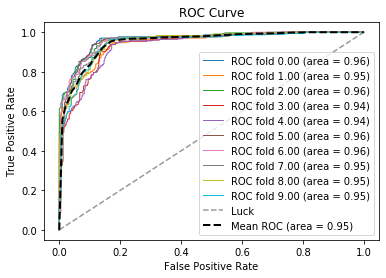

In [11]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

%matplotlib inline

cv = StratifiedKFold(n_splits=10)    #导入该模型，后面将数据划分10份
 
# 画平均ROC曲线的两个参数
mean_tpr = 0.0              # 用来记录画平均ROC曲线的信息
mean_fpr = np.linspace(0, 1, 100)
cnt = 0
for i, (train, test) in enumerate(cv.split(X_train_std,y_train)):       #利用模型划分数据集和目标变量 为一一对应的下标
    cnt +=1
    probas_ = svc.fit(X_train_std[train], y_train[train]).predict_proba(X_train_std[test]) # 训练模型后预测每条样本得到两种结果的概率
    fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:, 1])    # 该函数得到伪正例、真正例、阈值，这里只使用前两个
 
    mean_tpr += np.interp(mean_fpr, fpr, tpr)   # 插值函数 interp(x坐标,每次x增加距离,y坐标)  累计每次循环的总值后面求平均值
    mean_tpr[0] = 0.0           # 将第一个真正例=0 以0为起点
 
    roc_auc = auc(fpr, tpr)  # 求auc面积
    plt.plot(fpr, tpr, lw=1, label='ROC fold {0:.2f} (area = {1:.2f})'.format(i, roc_auc))    # 画出当前分割数据的ROC曲线

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck') # 画对角线
 
mean_tpr /= cnt   # 求数组的平均值
mean_tpr[-1] = 1.0   # 坐标最后一个点为（1,1）  以1为终点
mean_auc = auc(mean_fpr, mean_tpr)
 
plt.plot(mean_fpr, mean_tpr, 'k--',label='Mean ROC (area = {0:.2f})'.format(mean_auc), lw=2)
 
plt.xlim([-0.05, 1.05])     # 设置x、y轴的上下限，设置宽一点，以免和边缘重合，可以更好的观察图像的整体
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')    # 可以使用中文，但需要导入一些库即字体
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [12]:
from sklearn import metrics
predict_target = svc.predict(X_test_std)
print(metrics.classification_report(y_test, predict_target, 
                                    target_names=['Good sanitize', 'Bad sanitize']))

               precision    recall  f1-score   support

Good sanitize       0.94      0.85      0.89      1718
 Bad sanitize       0.82      0.93      0.87      1306

     accuracy                           0.88      3024
    macro avg       0.88      0.89      0.88      3024
 weighted avg       0.89      0.88      0.88      3024



Text(0.5, 0, 'True label')

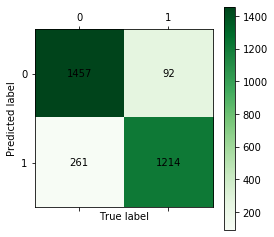

In [13]:
# Confusion matrix
%matplotlib inline

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, svc.predict(X_test_std))
plt.matshow(cm,cmap=plt.cm.Greens)
plt.colorbar()
for x in range(len(cm)):
    for y in range(len(cm)):
        plt.annotate(cm[x,y],xy=(x,y),horizontalalignment='center',verticalalignment='center')

plt.ylabel('Predicted label')# 坐标轴标签
plt.xlabel('True label')# 坐标轴标签